In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import torch

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

import utils.torchUtils as gnn

In [2]:
template = gnn.Dataset("../data/template",make_template=True, transform=gnn.HyperEdgeY())

In [3]:
model = gnn.modelMap['golden_hyper_edge'].load_from_checkpoint(
    "/uscms_data/d3/ekoenig/8BAnalysis/studies/sixbStudies/jupyter/eightb/pairing_methods/graph_net/models/golden_hyper_edge/lightning_logs/version_9/checkpoints/epoch=34-step=12634.ckpt"
    ,dataset=template).to(device=gnn.config.device)

In [4]:
bkgtrees = ObjIter([Tree(fc.eightb.preselection.QCD_B_List)])

In [5]:
# signaltrees = ObjIter([Tree(fc.eightb.preselection.signal_list[i]) for i in (0,4,7)])
signaltrees = ObjIter([Tree(fc.eightb.preselection.signal_list[i]) for i in (0,4,7)])

In [6]:
for tree in signaltrees: tree.color=None

In [7]:
def get_tree_graph(tree, ver='testing', path='../data'):
    sample = tree.sample
    dataset = gnn.Dataset(f'{path}/{sample}-{ver}', transform=template.transform)
    loader = gnn.DataLoader(dataset, batch_size=50, num_workers=gnn.config.ncpu)
    tree.graphs = loader

def get_qcd_graph(tree, path='../data'):
    get_name = lambda f : f.fname.split('/')[-2]
    dataset = gnn.concat_dataset([f'{path}/{sample}' for sample in map(get_name, tree.filelist)],transform=template.transform)
    loader = gnn.DataLoader(dataset, batch_size=50, num_workers=gnn.config.ncpu)
    tree.graphs = loader

In [8]:
signaltrees.apply(get_tree_graph)
bkgtrees.apply(get_qcd_graph)

[None]

In [9]:
def predict_model(model, data):
    with torch.no_grad():
        node_o, edge_o, hyper_o = model(data.to(device=model.device))
    return torch.exp(node_o[:,1]), torch.exp(edge_o[:,1]), torch.exp(hyper_o[:,1])

In [10]:
def ak_combs(array, n, **kwargs):
    return ak.concatenate([ i[:,:,None] for i in ak.unzip(ak.combinations(array, n, **kwargs))],axis=-1)
def ak_perms(array, n, **kwargs):
    return ak.concatenate([ i[:,:,None] for i in ak.unzip(ak.cartesian([array]*n, **kwargs))],axis=-1)
def ak_find_best_comb(selected,  n_pairs, all_combs, all_comb_score):
    combs = ak_combs(selected, n_pairs)
    combs_idx = ak.argmax(ak.all(combs[:,:,None] == all_combs[:,None],axis=-1),axis=-1)
    best_combs_idx = ak.argmax(all_comb_score[combs_idx],axis=-1)
    best_combs_idx = combs_idx[ak.local_index(combs_idx,axis=-1) == best_combs_idx][:,0]
    comb_1 = all_combs[ak.local_index(all_combs,axis=1) == best_combs_idx][:,0]
    comb_2 = selected[~ak.any(selected[:,:,None] == comb_1[:,None],axis=-1)]
    return comb_1, comb_2
def ak_order_higgs(higgs, all_combs, all_comb_score):
    selected = ak.concatenate(higgs,axis=-1)
    combs = ak.concatenate([ ak.concatenate((hi, hj),axis=-1)[:,None] for i,hi in enumerate(higgs) for hj in higgs[i+1:] ],axis=1)
    sorted_combs = ak.sort(combs,axis=-1)
    combs_idx = ak.argmax(ak.all(sorted_combs[:,:,None] == all_combs[:,None],axis=-1),axis=-1)
    best_combs_idx = ak.argmax(all_comb_score[combs_idx],axis=-1)
    comb_1 = combs[ak.local_index(combs_idx,axis=-1) == best_combs_idx][:,0]
    comb_2 = selected[~ak.any(selected[:,:,None] == comb_1[:,None],axis=-1)]
    return comb_1, comb_2
def batch_select_higgs(model, batch):
    node_o, edge_o, hyper_o = predict_model(model, batch)
    n_nodes = (batch.ptr[1:]-batch.ptr[:-1]).numpy()

    jet_idx = ak.local_index(ak.unflatten(np.repeat(n_nodes,n_nodes),n_nodes),axis=-1)
    n_nodes = n_nodes.astype(int)
    n_edges = n_nodes**2
    n_hyper = n_nodes*(n_nodes-1)*(n_nodes-2)*(n_nodes-3)//24
    ak_node_o = ak.unflatten(node_o, n_nodes)
    ak_edge_o = ak.unflatten(edge_o, n_edges)
    ak_hyper_o = ak.unflatten(hyper_o, n_hyper)

    ak_edge_index = ak_perms(jet_idx, 2)
    ak_edge_mask = ak_edge_index[:,:,0] < ak_edge_index[:,:,1]
    ak_edge_index = ak.sort(ak_edge_index[ak_edge_mask],axis=-1)
    ak_edge_o = ak_edge_o[ak_edge_mask]

    h1, remaining = ak_find_best_comb(jet_idx,   2, ak_edge_index, ak_edge_o)
    h2, remaining = ak_find_best_comb(remaining, 2, ak_edge_index, ak_edge_o)
    h3, remaining = ak_find_best_comb(remaining, 2, ak_edge_index, ak_edge_o)
    h4, remaining = ak_find_best_comb(remaining, 2, ak_edge_index, ak_edge_o)

    ak_hyper_index = ak_combs(jet_idx, 4)
    y1, y2 = ak_order_higgs([h1,h2,h3,h4], ak_hyper_index, ak_hyper_o)
    
    selected_jets = ak.concatenate([y1,y2], axis=-1)
    return selected_jets
def batch_select_jets(model, batch):
    node_o, edge_o, hyper_o = predict_model(model, batch)
    n_nodes = (batch.ptr[1:]-batch.ptr[:-1]).numpy()

    jet_idx = ak.local_index(ak.unflatten(np.repeat(n_nodes,n_nodes),n_nodes),axis=-1)
    n_nodes = n_nodes.astype(int)
    n_edges = n_nodes**2
    n_hyper = n_nodes*(n_nodes-1)*(n_nodes-2)*(n_nodes-3)//24
    ak_node_o = ak.unflatten(node_o, n_nodes)
    ak_edge_o = ak.unflatten(edge_o, n_edges)
    ak_hyper_o = ak.unflatten(hyper_o, n_hyper)

    selected_nodes = ak.argsort(-ak_node_o,axis=-1)[:,:8]
    selected_nodes = ak.sort(selected_nodes,axis=-1)
    
    ak_hyper_index = ak_combs(jet_idx, 4)
    y1_comb, y2_comb = ak_find_best_comb(selected_nodes, 4, ak_hyper_index, ak_hyper_o)

    ak_edge_index = ak_perms(jet_idx, 2)
    ak_edge_mask = ak_edge_index[:,:,0] < ak_edge_index[:,:,1]
    ak_edge_index = ak.sort(ak_edge_index[ak_edge_mask],axis=-1)
    ak_edge_o = ak_edge_o[ak_edge_mask]
    h1y1_comb, h2y1_comb = ak_find_best_comb(y1_comb, 2, ak_edge_index, ak_edge_o)
    h1y2_comb, h2y2_comb = ak_find_best_comb(y2_comb, 2, ak_edge_index, ak_edge_o)

    selected_jets = ak.concatenate([h1y1_comb,h2y1_comb,h1y2_comb,h2y2_comb],axis=-1)
    return selected_jets
def gnn_select_jets(tree, model=model):
    selected_jet_idx = ak.concatenate([
        batch_select_jets(model, batch)
        for batch in tree.graphs
    ])
    tree.extend(selected_jet_idx=selected_jet_idx)

def gnn_select_higgs(tree, model=model):
    selected_jet_idx = ak.concatenate([
        batch_select_higgs(model, batch)
        for batch in tree.graphs
    ])
    tree.extend(selected_jet_idx=selected_jet_idx)

In [11]:
(bkgtrees+signaltrees).apply(build_all_dijets)

[None, None, None, None]

In [12]:
def predict_tree(tree):
    node_scores, edge_itoj_scores, edge_jtoi_scores, hyper_scores = [],[],[],[]
    hyper_truth = []
    for graph in tree.graphs:
        node_score, edge_score,hyper_score = predict_model(model, graph)
        node_scores.append(node_score)
        
        node_i, node_j = graph.edge_index
        i_to_j = node_i < node_j
        j_to_i = node_j < node_i
        edge_itoj_scores.append(edge_score[i_to_j])
        edge_jtoi_scores.append(edge_score[j_to_i])

        hyper_scores.append(hyper_score)
        hyper_truth.append(graph.hyper_edge_y)
        
    node_scores = torch.cat(node_scores).cpu().numpy()
    edge_itoj_scores = torch.cat(edge_itoj_scores).cpu().numpy()
    edge_jtoi_scores = torch.cat(edge_jtoi_scores).cpu().numpy()
    hyper_scores = torch.cat(hyper_scores).cpu().numpy()
    hyper_truth = torch.cat(hyper_truth).cpu().numpy()
    
    n_nodes = ak.num(tree.jet_pt)
    n_edges = ak.num(tree.dijet_pt)
    n_hyper = n_nodes*(n_nodes-1)*(n_nodes-2)*(n_nodes-3)//24

    node_scores = ak.unflatten(node_scores,n_nodes)
    edge_itoj_scores = ak.unflatten(edge_itoj_scores,n_edges)
    edge_jtoi_scores = ak.unflatten(edge_jtoi_scores,n_edges)
    hyper_scores = ak.unflatten(hyper_scores,n_hyper)
    hyper_truth = ak.unflatten(hyper_truth,n_hyper)
    
    
    tree.extend(
        jet_score = node_scores,
        dijet_itoj_score = edge_itoj_scores,
        dijet_jtoi_score = edge_jtoi_scores,
        qujet_score = hyper_scores,
        qujet_signalId = hyper_truth,
    )

In [13]:
# signaltrees.apply(gnn_select_higgs)
(bkgtrees+signaltrees).apply(predict_tree)

[None, None, None, None]

# GNN Model

Trained GNN model to predict:

    Node level classification:     is jet from a higgs?
    Edge level classification:     are these two jets from the same higgs?
    4 Node cluster classification: are these four jets from the same Y?

Graph features used:

    Node features: Jet M, Pt, eta, phi, b-tag score
    Edge features: Di-Jet M, delta Pt, delta eta, delta phi, delta R

Algorithm:

    Events are organized into a fully connected graph where each node in the graph represents a jet

    The first 2 layers of the GNN perform message passing:
        These layers exchange information between connected nodes, updating the features in each node and edge
        
    3 different dense linear (MLP) output layers to classify each part of the graph
        Node level MLP used to classify nodes
        Edge level MLP used to classify edges
        Every possible grouping of 4 (nCr(N,4)) nodes is pooled together then,
            these possible Y candidates are passed to a MLP classify these clusters

Preselection: all events must pass a preselection 

    Pass trigger selection
    8 Jets pass the filter requirements:
        Jet Pt > 20
        Jet |eta| < 2.5
        Jet tightID & puID

        

In [14]:
bkgtrees.extend(kwargs=lambda t : dict(nfound_presel=ak.zeros_like(t.n_jet)))

[None]

# Node Level Classification

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


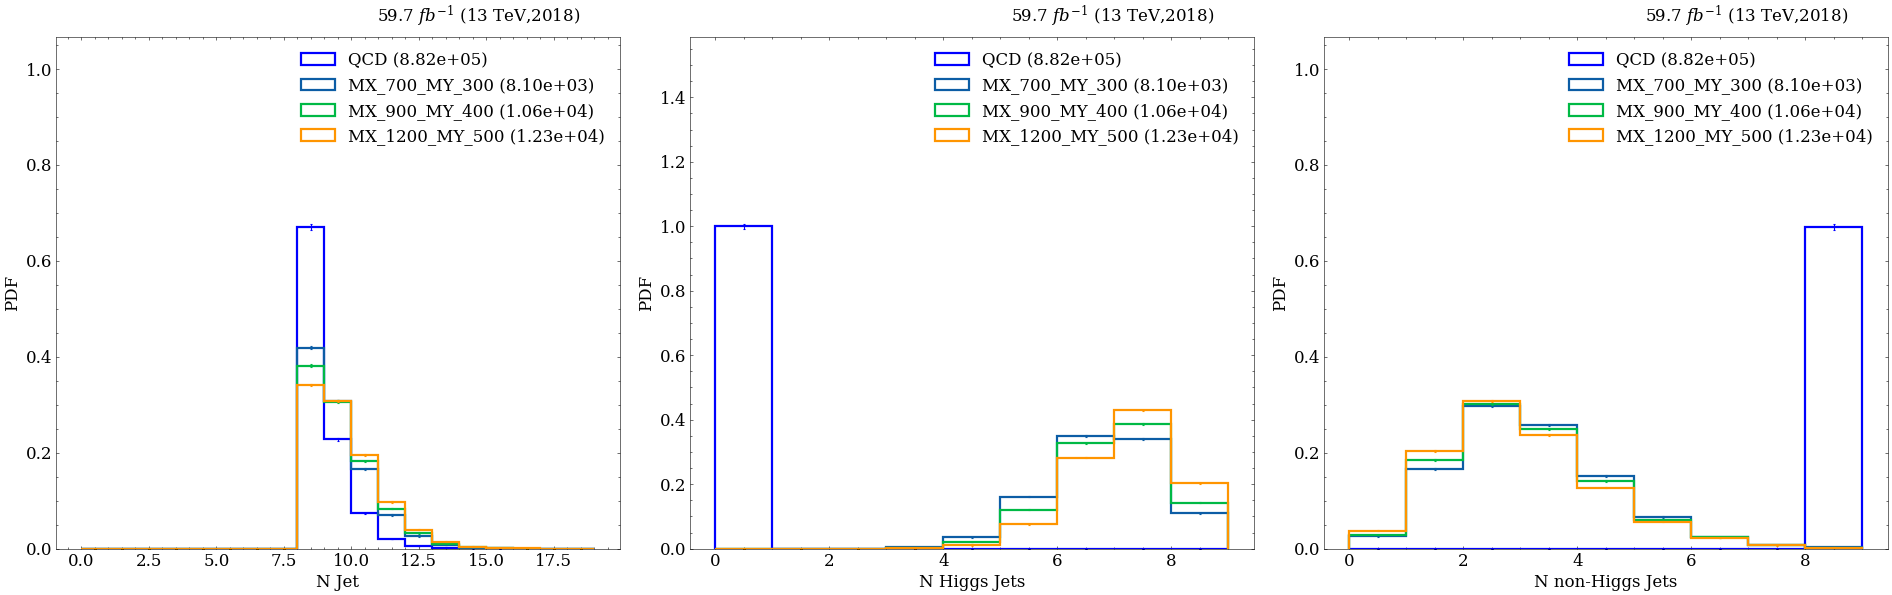

In [15]:
varinfo.clear()
study.quick(
    bkgtrees+signaltrees,
    varlist=['n_jet','nfound_presel',lambda t:t.n_jet-t.nfound_presel],
    xlabels=["N Jet","N Higgs Jets","N non-Higgs Jets"],
    binlist=[np.arange(20),np.arange(10),np.arange(10)],
    legend=True,density=True,
    dim=(-1,3),
    size=(8,8),

    # ratio=True,r_inv=True,r_ylim=(0.1,1.9)
)

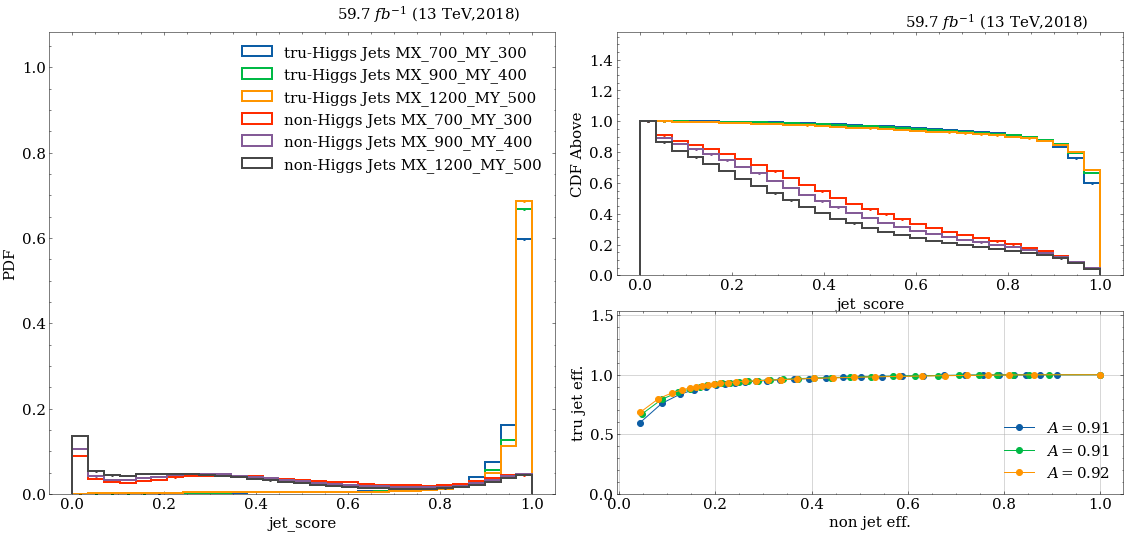

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(16,8))


masks=[lambda t : t.jet_signalId > -1]*3+[lambda t : t.jet_signalId == -1]*3
label=signaltrees.sample.apply(lambda n : f'tru-Higgs Jets {n}').list+signaltrees.sample.apply(lambda n : f'non-Higgs Jets {n}').list

study.quick(
    signaltrees+signaltrees,
    masks=masks,
    label=label,
    varlist=['jet_score'], binlist=[np.linspace(0,1,30)],
    h_label_stat=None,legend=True,
    density=True,
    size=(10,8),
    # cumulative=-1,
    # correlation=True, c_group=[(0,3),(1,4),(2,5)]

    figax=(fig,axs[0]),
)

study.quick(
    signaltrees+signaltrees,
    masks=masks,
    label=label,
    varlist=['jet_score'], binlist=[np.linspace(0,1,30)],
    # h_label_stat=None,legend=True,density=True,
    size=(10,8),
    cumulative=-1,
    correlation=True, c_group=[(3,0),(4,1),(5,2)], c_ylabel='tru jet eff.', c_xlabel='non jet eff.',

    figax=(fig,axs[1]),

)

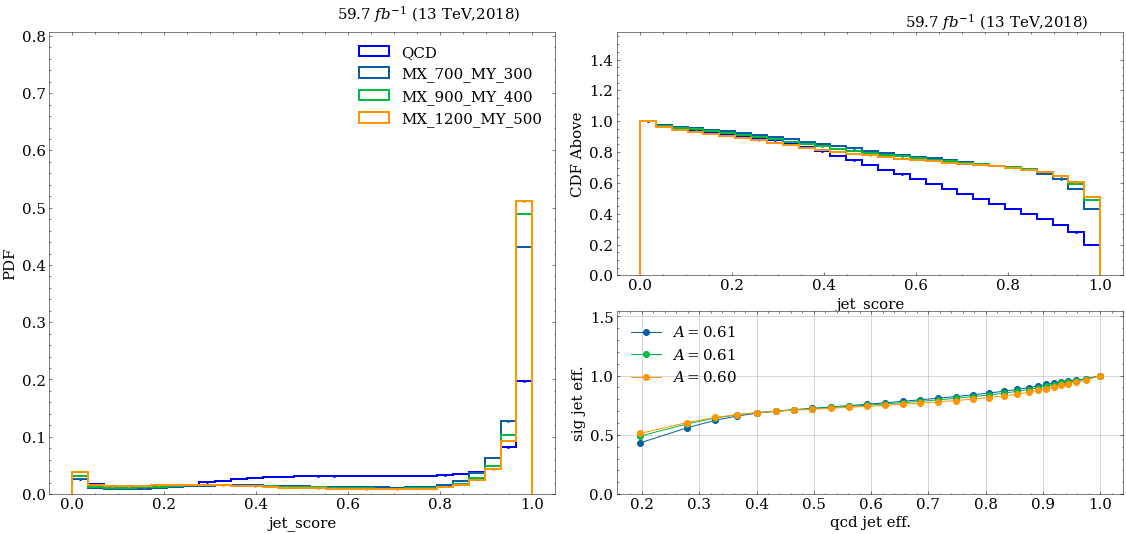

In [17]:
fig, axs = plt.subplots(ncols=2, figsize=(16,8))


study.quick(
    bkgtrees+signaltrees,
    varlist=['jet_score'], binlist=[np.linspace(0,1,30)],
    h_label_stat=None,legend=True,
    density=True,
    size=(10,8),
    # cumulative=-1,
    # correlation=True, c_group=[(0,3),(1,4),(2,5)]

    figax=(fig,axs[0]),
)

study.quick(
    bkgtrees+signaltrees,
    varlist=['jet_score'], binlist=[np.linspace(0,1,30)],
    # h_label_stat=None,legend=True,density=True,
    size=(10,8),
    cumulative=-1,
    correlation=True, c_ylabel='sig jet eff.', c_xlabel='qcd jet eff.',

    figax=(fig,axs[1]),

)

# Edge Level Classification

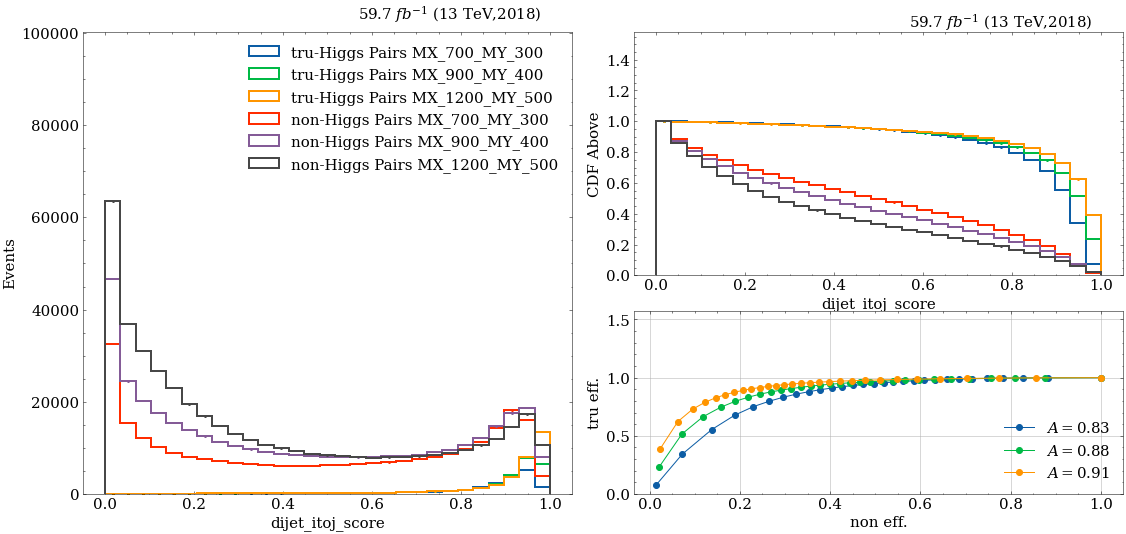

In [18]:
fig, axs = plt.subplots(ncols=2, figsize=(16,8))

study.quick(
    signaltrees+signaltrees,
    masks=[lambda t : t.dijet_signalId > -1]*3+[lambda t : t.dijet_signalId == -1]*3,
    varlist=['dijet_itoj_score'], binlist=[np.linspace(0,1,30)],
    label=signaltrees.sample.apply(lambda n : f'tru-Higgs Pairs {n}').list+signaltrees.sample.apply(lambda n : f'non-Higgs Pairs {n}').list,
    h_label_stat=None,legend=True,
    # density=True,
    size=(10,8),
    # cumulative=-1,
    # correlation=True, c_group=[(0,3),(1,4),(2,5)]

    figax=(fig,axs[0]),
)

study.quick(
    signaltrees+signaltrees,
    masks=[lambda t : t.dijet_signalId > -1]*3+[lambda t : t.dijet_signalId == -1]*3,
    varlist=['dijet_itoj_score'], binlist=[np.linspace(0,1,30)],
    label=signaltrees.sample.apply(lambda n : f'tru-Higgs Pairs {n}').list+signaltrees.sample.apply(lambda n : f'non-Higgs Pairs {n}').list,
    # h_label_stat=None,legend=True,
#     size=(10,8),
    cumulative=-1,
    correlation=True, c_group=[(3,0),(4,1),(5,2)], c_ylabel='tru eff.', c_xlabel='non eff.',

    figax=(fig,axs[1]),

)

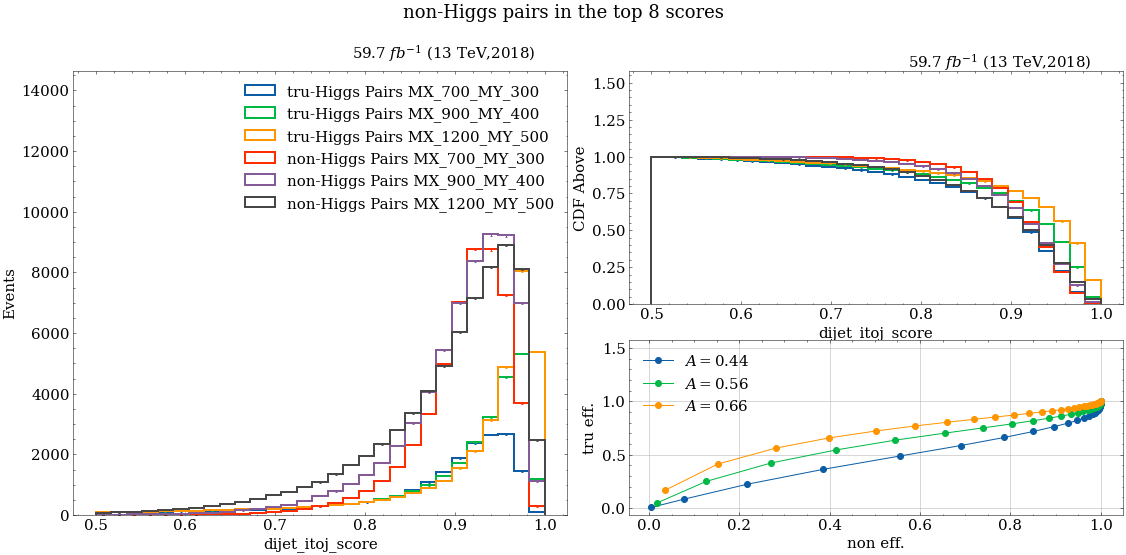

In [19]:
fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(16,8))

def true_mask(tree): 
    true_pair = tree.dijet_signalId > -1
    bin_cut = tree.dijet_itoj_score > 0.5
    return true_pair & bin_cut
def fake_mask(tree):
    fake_pair = tree.dijet_signalId == -1
    true_jet = (tree.jet_signalId[tree.dijet_j1Idx] > -1) & (tree.jet_signalId[tree.dijet_j2Idx] > -1)

    score = tree.dijet_itoj_score
    top8 = ak.argsort(-score)[:,:8]
    top8_mask = get_jet_index_mask(score, top8)
    

    bin_cut = tree.dijet_itoj_score > 0.5


    return fake_pair & bin_cut & top8_mask


masks=[true_mask]*3+[fake_mask]*3
label=signaltrees.sample.apply(lambda n : f'tru-Higgs Pairs {n}').list+signaltrees.sample.apply(lambda n : f'non-Higgs Pairs {n}').list

study.quick(
    signaltrees+signaltrees,
    masks=masks,
    varlist=['dijet_itoj_score'], binlist=[np.linspace(0.5,1,30)],
    label=label,
    h_label_stat=None,legend=True,
    # density=True,
    size=(10,8),
    # cumulative=-1,
    # correlation=True, c_group=[(0,3),(1,4),(2,5)]

    figax=(fig,axs[0]),
)

study.quick(
    signaltrees+signaltrees,
    masks=masks,
    varlist=['dijet_itoj_score'], binlist=[np.linspace(0.5,1,30)],
    label=label,
    # h_label_stat=None,legend=True,
#     size=(10,8),
    cumulative=-1,
    correlation=True, c_group=[(3,0),(4,1),(5,2)], c_ylabel='tru eff.', c_xlabel='non eff.',

    figax=(fig,axs[1]),

)
fig.suptitle('non-Higgs pairs in the top 8 scores')
fig.tight_layout()

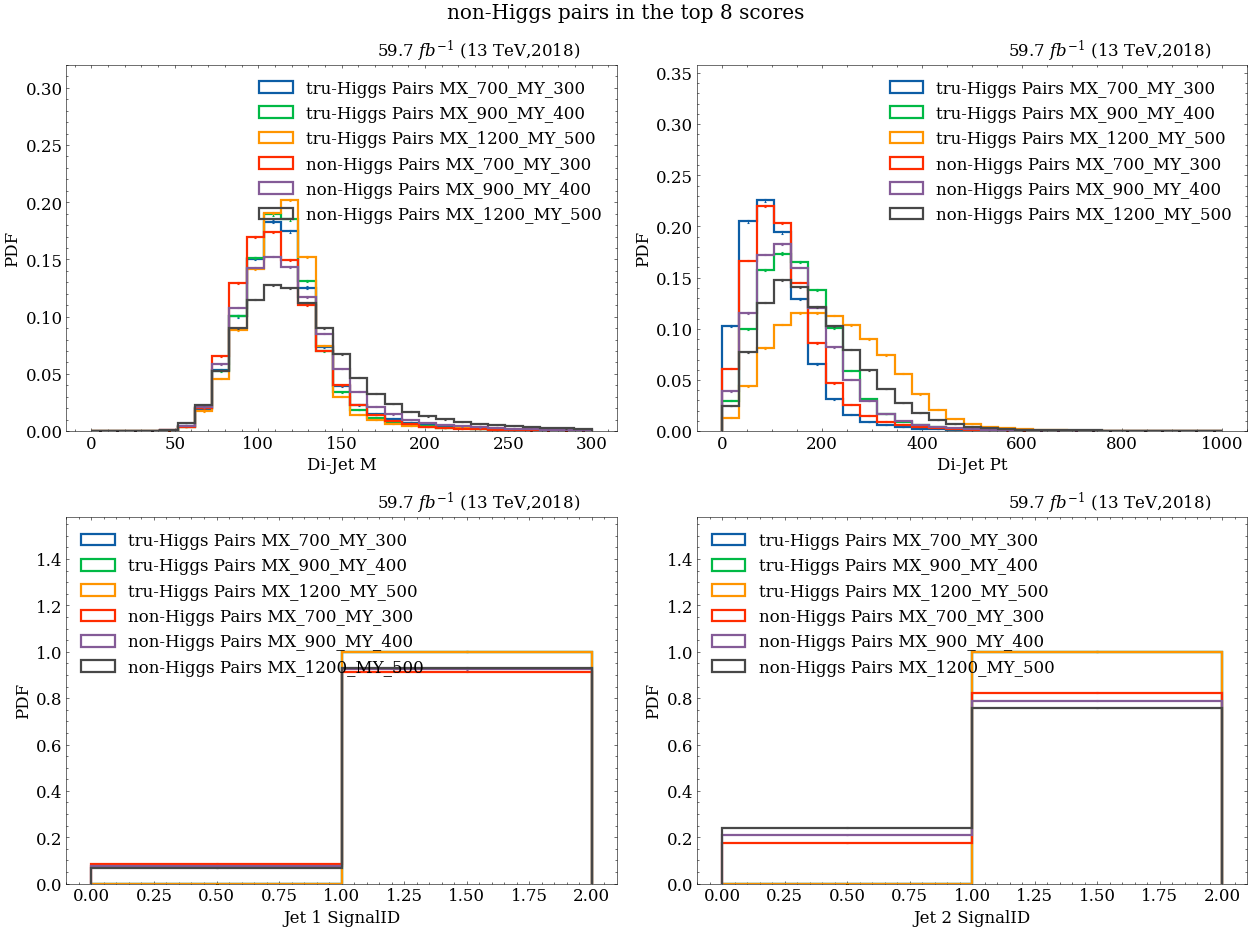

In [20]:
study.quick(
    signaltrees+signaltrees,
    masks=masks,
    varlist=['dijet_m','dijet_pt', lambda t : ak.where(t.jet_signalId[t.dijet_j1Idx]==-1,0,1), lambda t : ak.where(t.jet_signalId[t.dijet_j2Idx]==-1,0,1)], 
    binlist=[np.linspace(0,300,30), np.linspace(0,1000,30)],
    xlabels=["Di-Jet M","Di-Jet Pt","Jet 1 SignalID","Jet 2 SignalID"],
    label=label,
    h_label_stat=None,legend=True,
    density=True,
    size=(8,6),
    # cumulative=-1,
    # correlation=True, c_group=[(0,3),(1,4),(2,5)]

    title='non-Higgs pairs in the top 8 scores',
)


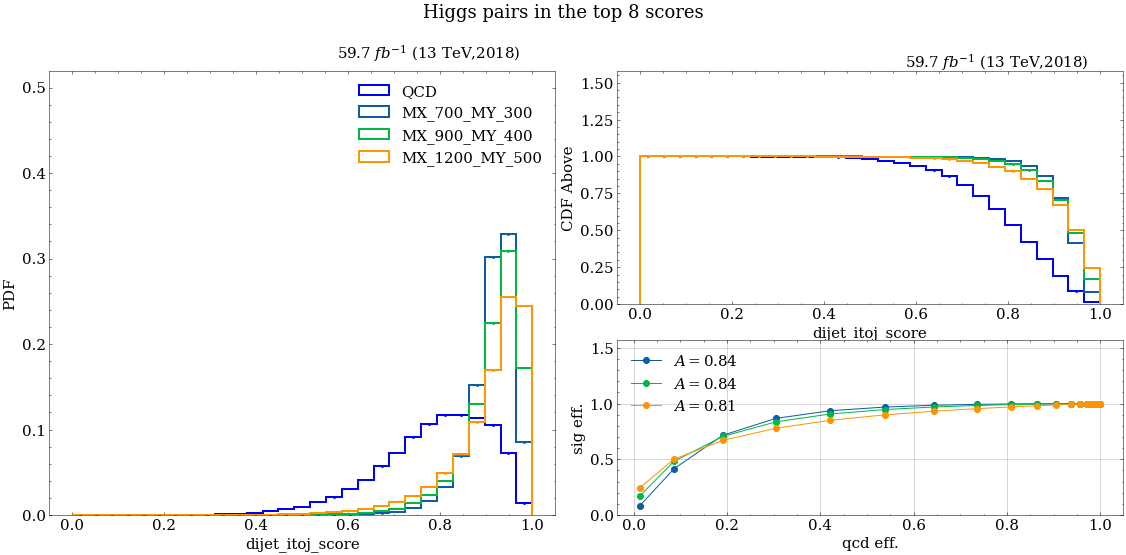

In [21]:
fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(16,8))

def top8_mask(tree):
    score = tree.dijet_itoj_score
    top8 = ak.argsort(-score)[:,:8]
    top8_mask = get_jet_index_mask(score, top8)
    return top8_mask


masks=top8_mask

study.quick(
    bkgtrees+signaltrees,
    masks=masks,
    varlist=['dijet_itoj_score'], binlist=[np.linspace(0,1,30)],
    h_label_stat=None,legend=True,
    density=True,
    size=(10,8),
    # cumulative=-1,
    # correlation=True, c_group=[(0,3),(1,4),(2,5)]

    figax=(fig,axs[0]),
)

study.quick(
    bkgtrees+signaltrees,
    masks=masks,
    varlist=['dijet_itoj_score'], binlist=[np.linspace(0,1,30)],
    # h_label_stat=None,legend=True,
#     size=(10,8),
    cumulative=-1,
    correlation=True, c_ylabel='sig eff.', c_xlabel='qcd eff.',

    figax=(fig,axs[1]),

)
fig.suptitle('Higgs pairs in the top 8 scores')
fig.tight_layout()

Algorithm to select which edges to use:

    GNN assigns a score to every possible pairing in the event
    We take the highest scoring pairs without pairing the same jet twice (each jet will have N different edges assigned a different score) 

In [22]:
(bkgtrees+signaltrees).apply(lambda t : select_higgs(t, field='itoj_score', nhiggs=4))

[None, None, None, None]

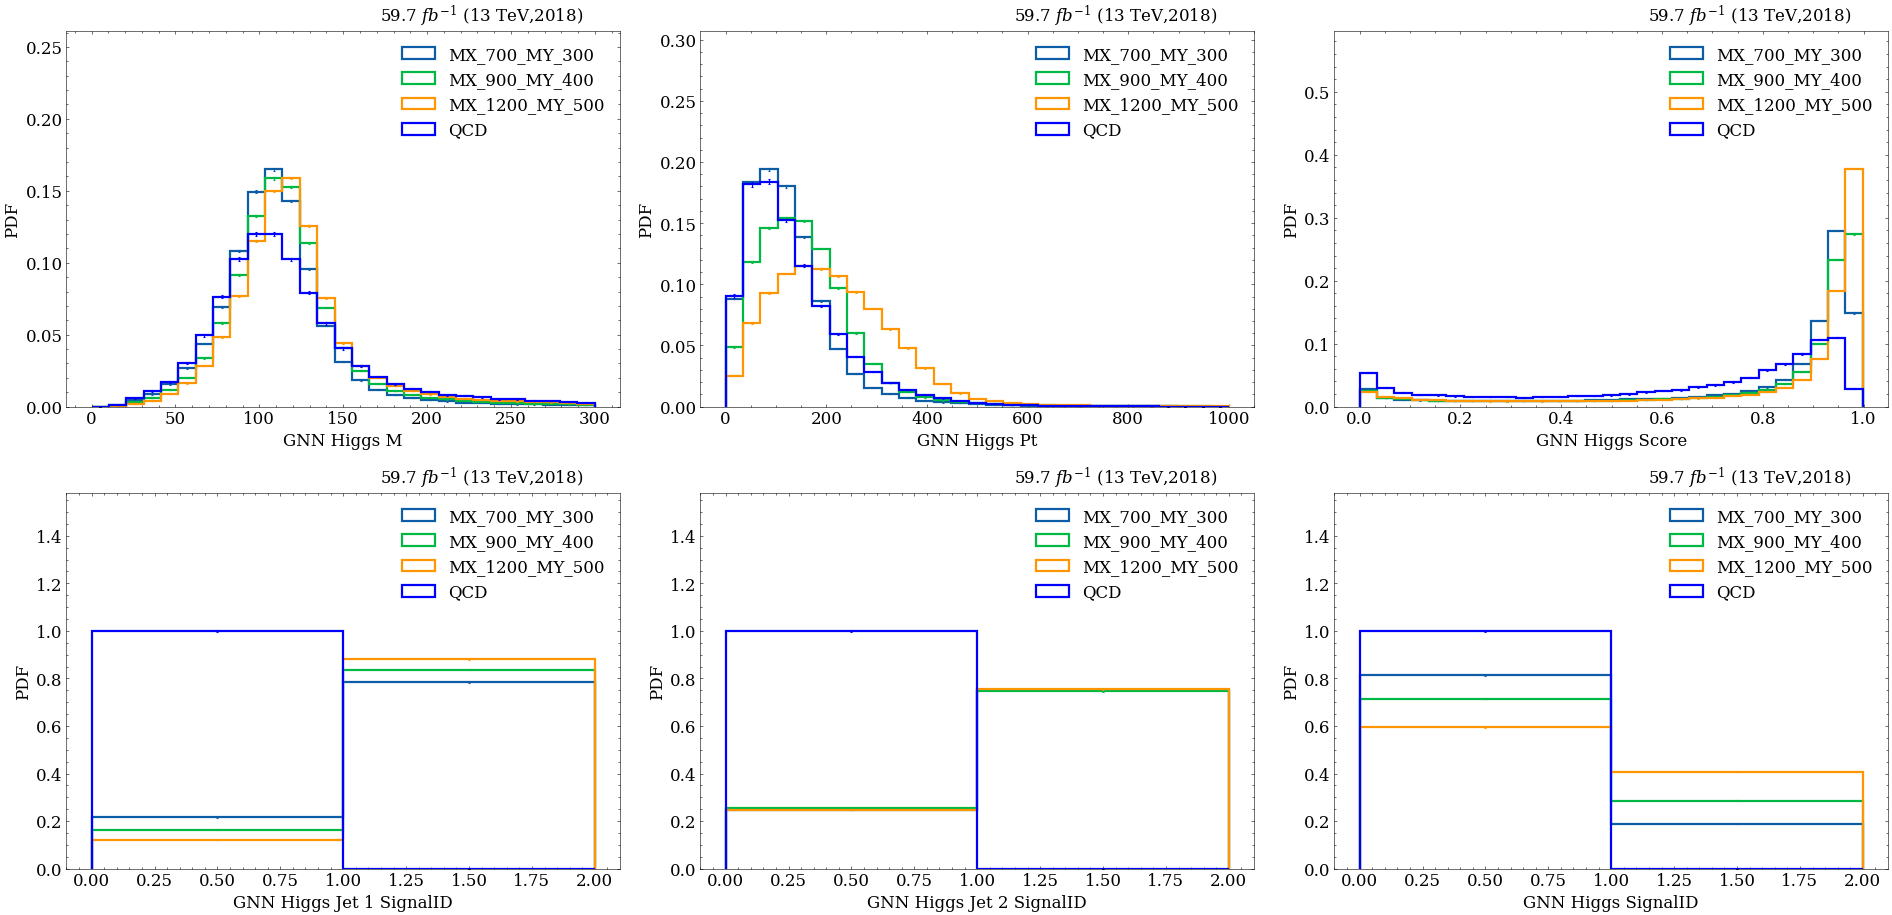

In [23]:
study.quick(
    signaltrees+bkgtrees,
    varlist=['gnn_higgs_m','gnn_higgs_pt', 'gnn_higgs_itoj_score',
    lambda t : ak.where(t.jet_signalId[t.gnn_higgs_j1Idx]==-1,0,1), lambda t : ak.where(t.jet_signalId[t.gnn_higgs_j2Idx]==-1,0,1), lambda t : ak.where(t.gnn_higgs_signalId==-1,0,1)], 
    binlist=[np.linspace(0,300,30), np.linspace(0,1000,30)],
    xlabels=["GNN Higgs M","GNN Higgs Pt","GNN Higgs Score","GNN Higgs Jet 1 SignalID","GNN Higgs Jet 2 SignalID","GNN Higgs SignalID"],
    # label=label,
    h_label_stat=None,legend=True,
    density=True,
    size=(8,6),dim=(-1,3),
    # cumulative=-1,
    # correlation=True, c_group=[(0,3),(1,4),(2,5)]

)


# 4 Node Cluster Classification

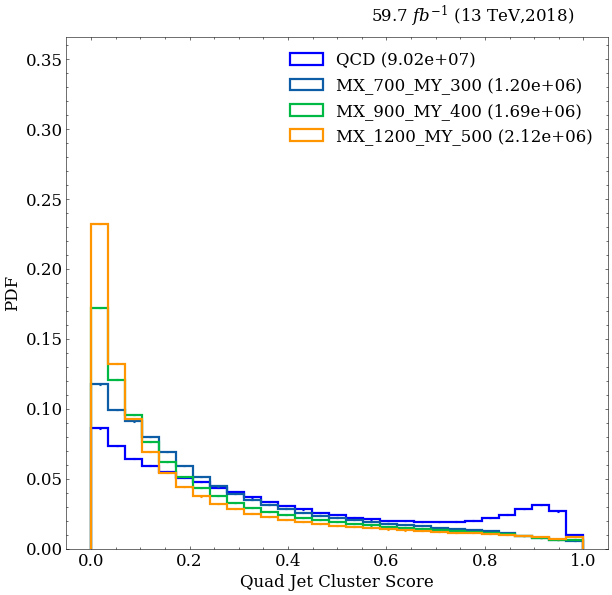

In [24]:
study.quick(
    bkgtrees+signaltrees,
    varlist=['qujet_score'],
    xlabels=["Quad Jet Cluster Score"],
    density=True,legend=True,
    size=(8,8),
)

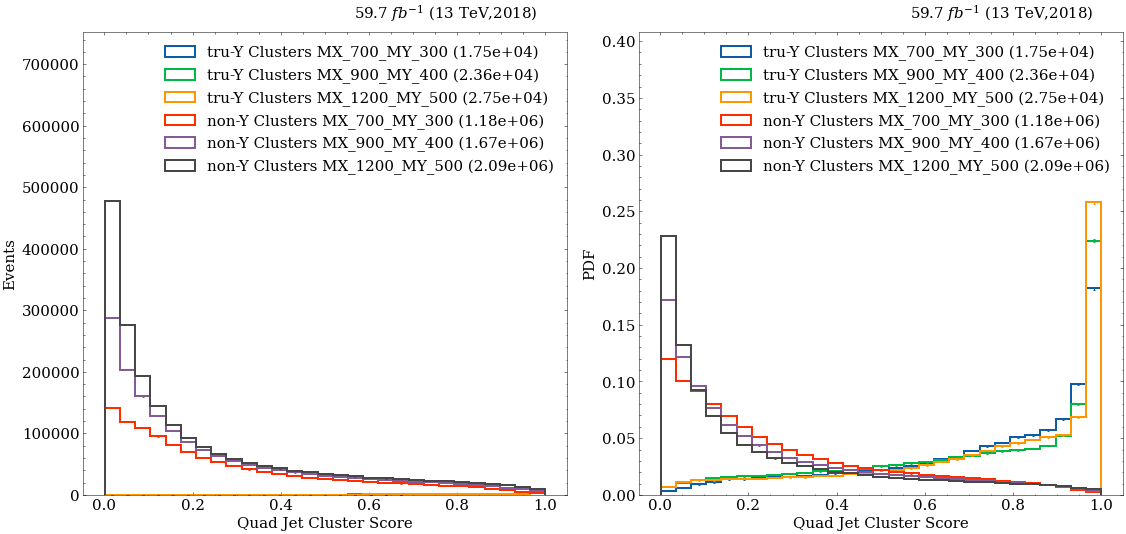

In [25]:
masks = [lambda t : t.qujet_signalId == 1]*3+[lambda t : t.qujet_signalId == 0]*3
label=signaltrees.sample.apply(lambda n : f'tru-Y Clusters {n}').list+signaltrees.sample.apply(lambda n : f'non-Y Clusters {n}').list

fig,axs=plt.subplots(ncols=2,figsize=(16,8))

study.quick(
    signaltrees+signaltrees,
    masks=masks,label=label,
    varlist=['qujet_score'],
    xlabels=["Quad Jet Cluster Score"],
    legend=True,
    # density=True,
    size=(8,8),
    figax=(fig,axs[0]),
)

study.quick(
    signaltrees+signaltrees,
    masks=masks,label=label,
    varlist=['qujet_score'],
    xlabels=["Quad Jet Cluster Score"],
    legend=True,
    density=True,
    size=(8,8),
    figax=(fig,axs[1]),
)

In [26]:
def sub_model(self, data):
    x, edge_index, edge_attr, hyper_edge_index = data.x, data.edge_index, data.edge_attr, data.hyper_edge_index
    x, edge_attr = self.conv1(x, edge_index, edge_attr)
    x, edge_attr = self.relu1(x, edge_index, edge_attr)

    x, edge_attr = self.conv2(x, edge_index, edge_attr)
    x, edge_attr = self.relu2(x, edge_index, edge_attr)

    return x, edge_attr

In [27]:
for batch in signaltrees[0].graphs: break
batch = batch.to(model.device)
x_o, edge_o, hyper_o = predict_model(model,batch)
sub_x, sub_edge_attr = sub_model(model,batch)

In [38]:
edge_y = batch.edge_y.detach().cpu().numpy()

In [50]:
np_edge_attr = sub_edge_attr.detach().cpu().numpy()
np_edge_o = edge_o.detach().cpu().numpy()

Text(0.5, 1.0, 'Edge Score > 0.75')

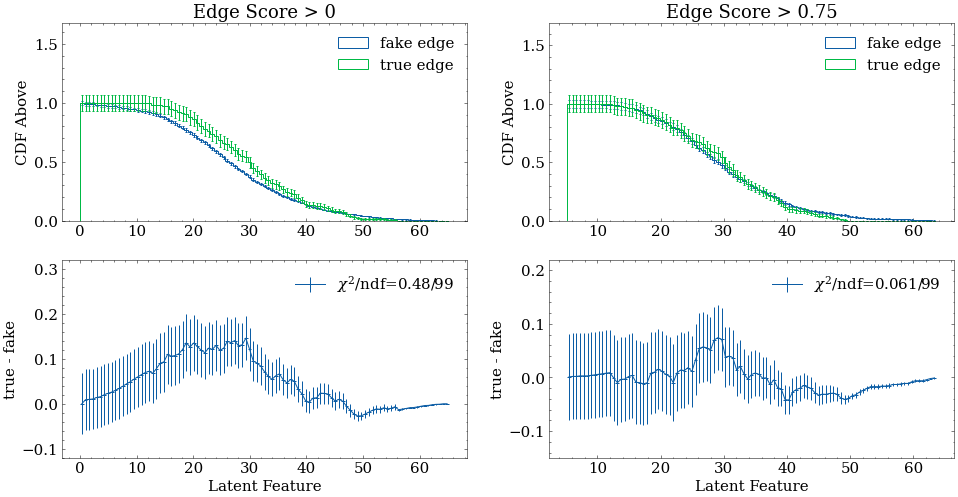

In [112]:
from utils.plotUtils.graph import Difference

masks = [edge_y==0 , edge_y==1]
def get_chi2(z, score=0.75, show=False, figax=None):
    arrays = [ z[mask & (np_edge_o>score)] for mask in masks ]

    minims = min([ ak.min(array) for array in arrays ])
    maxims = max([ ak.max(array) for array in arrays ]) 
    bins = np.linspace(minims,maxims,100)

    hists = HistoList(arrays, bins=bins, cumulative=-1, histtype='step', label=['fake edge','true edge'], label_stat='event')
    diff = Difference(hists[1],hists[0], label_stat='chi2')
    
    if show:
        if figax is None:
            figax = plt.subplots(nrows=2, figsize=(8,8))
        fig,axs = figax
        plot_histos(hists, figax=(fig,axs[0]), legend=True, ylabel='CDF Above')
        plot_graph(diff, figax=(fig,axs[1]), legend=True, ylabel='true - fake', xlabel="Latent Feature")

    return diff.stats.chi2


fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(16,8))
get_chi2(np_edge_attr.T[0], 0, show=True,figax=(fig,axs[:,0]))
get_chi2(np_edge_attr.T[0], 0.75, show=True,figax=(fig,axs[:,1]))
axs[0,0].set_title('Edge Score > 0')
axs[0,1].set_title('Edge Score > 0.75')


(<Figure size 720x360 with 2 Axes>,
 <AxesSubplot:title={'center':'Edge Score > 0.75'}, xlabel='Latent Feature $\\sum\\chi^2$', ylabel='Counts'>)

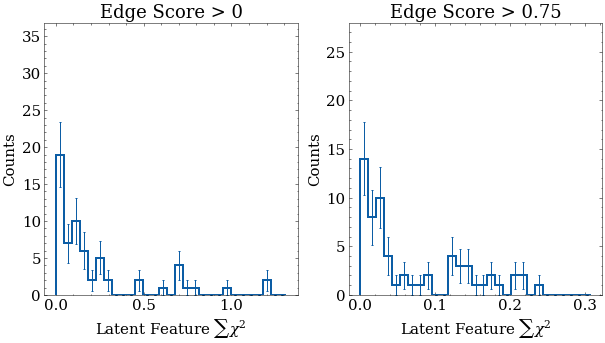

In [114]:
fig,axs = plt.subplots(ncols=2, figsize=(10,5))
hist_multi([ak.Array([ get_chi2(z, 0) for z in np_edge_attr.T ])], xlabel='Latent Feature $\sum\chi^2$', ylabel='Counts', figax=(fig,axs[0]), title='Edge Score > 0')
hist_multi([ak.Array([ get_chi2(z, 0.75) for z in np_edge_attr.T ])], xlabel='Latent Feature $\sum\chi^2$', ylabel='Counts', figax=(fig,axs[1]), title='Edge Score > 0.75')